In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
from scipy.optimize import curve_fit
import pandas as pd
from scipy import stats
from matplotlib.lines import Line2D

import matplotlib.ticker as mticker

from astropy.io import fits
import matplotlib.gridspec as gridspec

from astropy.wcs import WCS
from numpy import loadtxt
import math

plt.rc('axes', titlesize=14)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=14)    # legend fontsize
plt.rc('figure', titlesize=16)

In [3]:
data = []
path_list = ['lofar_2021/flux_densities_0.054GHz_LOFAR.txt',
             'lofar_2021/flux_densities_0.15GHz_LOFAR.txt',
            'kantharia_etal_2007/flux_densities_0.15GHz.txt',
            'kantharia_etal_2007/flux_densities_0.24GHz.txt',
            'kantharia_etal_2007/flux_densities_0.325GHz.txt', 
            'kantharia_etal_2007/flux_densities_0.61GHz.txt',
            'meerkat_2021/flux_densities_0.8GHz_updated.txt', #_adjusted
            'meerkat_2021/flux_densities_1.3GHz_updated.txt', #_adjusted
            'vla_2021/vla_2_6GHz_2021.txt', 'vla_2021/vla_3_4GHz_2021.txt',
             'vla_2021/vla_5_1GHz_2021.txt', 'vlba_2006/flux_densities_1.7GHz_east_lobe.txt']

for path in path_list:
    sub=np.genfromtxt('../data/light_curve_data/'+path, dtype=float, skip_header=2, 
                  comments='#', delimiter='\t',names=True)
    data.append(sub)


# Entries with a flux error of 0 are upper limits
# Systematic flux errors for meerkat and lofar are included in the data file.

## RS Oph 2021 data
## Indices, input file

0,'lofar_2021/flux_densities_0.054GHz_LOFAR.txt'

1,'lofar_2021/flux_densities_0.15GHz_LOFAR_adjusted.txt'

2,'kantharia_etal_2007/flux_densities_0.15GHz.txt'

3,'kantharia_etal_2007/flux_densities_0.24GHz.txt'

4,'kantharia_etal_2007/flux_densities_0.325GHz.txt'

5,'kantharia_etal_2007/flux_densities_0.61GHz.txt'

6,'meerkat_2021/flux_densities_0.8GHz_adjusted.txt'

7,'meerkat_2021/flux_densities_1.3GHz_adjusted.txt'

8,'vla_2021/vla_2_6GHz_2021.txt

9,'vla_2021/vla_3_4GHz_2021.txt'

10,'vla_2021/vla_5_1GHz_2021.txt'

11,'vlba_2006/flux_densities_1.7GHz_east_lobe.txt'

In [4]:
label_list = ['LOFAR 54 MHz','LOFAR 154 MHz','GMRT 150 MHz 2006 (Kantharia et al 2007)',
                 'GMRT 240 MHz 2006 (Kantharia et al 2007)', 'GMRT 325 MHz 2006 (Kantharia et al 2007)',
                 'GMRT 610 MHz 2006 (Kantharia et al 2007)', 'MeerKAT 800 MHz','MeerKAT 1.3 GHz', 'VLA 2.6 GHz 2021',
              'VLA 3.4 GHz 2021','VLA 5.1 GHz 2021', 'VLBA 1.7 GHz 2006 east', 'VLBA 1.7 GHz 2006 west']
nu_list = [54, 154, 150, 240, 325, 610, 830, 1280, 2600, 3400,5100, 1700,1700]

# Physical description

From Weiler et al. 2002 https://www.annualreviews.org/doi/pdf/10.1146/annurev.astro.40.060401.093744

<b>The characteristic RSN radio light curves arise from the competing effects of slowly declining nonthermal radio emission and more rapidly declining thermal or nonthermal absorption yielding a rapid turn-on and slower turn-off of the radio emission at any single frequency. Because absorption processes are greater at lower frequencies, transition
from optically thick to optically thin (turn-on) occurs first at higher frequencies and later at lower frequencies</b>


Chevalier (1982a,b) has proposed that the relativistic electrons and enhanced magnetic field necessary for synchrotron emission arise from the supernova blastwave interacting with a relatively high-density CSM that has been ionized and
heated by the initial UV/X-ray flash. This CSM density ($\rho$), which decreases as the inverse square of the radius (r) from the star is presumed to have been established by a constant mass-loss ($\dot{M}$) rate, constant velocity ($w_{wind}$) wind (i.e., $\rho \propto \frac{\dot{M}}{w_{wind}r^2}$) from a massive stellar progenitor or companion. This ionized CSM is the source of some or all of the initial thermal gas absorption, although Chevalier (1998) has proposed that synchrotron self-absorption (SSA) may play a role in some objects. A rapid rise in the observed radio flux density results from a decrease in these absorption processes as the radio-emitting region expands and the absorption processes, either internal or along the line of sight, decrease. Weiler et al. (1990) have suggested that this CSM can be “clumpy” or “filamentary,” leading to a slower radio turn-on, and Montes et al. (1997) have proposed the possible presence of an additional ionized medium along the line of sight that is sufficiently distant from
the explosion that it is unaffected by the blastwave and can cause a spectral turnover at low radio frequencies.

# Light curve model
From Kantharia et al. 2007
https://iopscience.iop.org/article/10.1086/522201/pdf

\begin{equation}
    S\;(\rm{mJy}) = K_1 \left(\frac{\nu}{1 \; \rm{GHz}} \right)^\alpha \left(\frac{t-t_0}{20 \; \rm{days}} \right)^\beta e^{-\tau_{\rm{homog}}^{\rm{CSM}}} \left(\frac{1-e^{-\tau_{\rm{clumps}}^{\rm{CSM}}}}{\tau_{\rm{clumps}}^{\rm{CSM}}} \right)
\end{equation}

where
\begin{equation}
    \tau_{\rm{homog}}^{\rm{CSM}} = K_2 \left(\frac{\nu}{1 \; \rm{GHz}} \right)^{-2.1} \left(\frac{t-t_0}{20 \; \rm{days}} \right)^\delta
\end{equation}
\begin{equation}
    \tau_{\rm{clumps}}^{\rm{CSM}} = K_3 \left(\frac{\nu}{1 \; \rm{GHz}} \right)^{-2.1} \left(\frac{t-t_0}{20 \; \rm{days}} \right)^{\delta \prime}
\end{equation}

with $K_1$, $K_2$, $K_3$, and $K_4$ determined from fits to the data and corresponding,
formally, to the flux density ($K_1$), uniform ($K_2$, $K_3$), and clumpy or filamentary
($K_3$) absorption at 1 GHz 20 days after the explosion date $t_0$. The terms $\tau_{\rm{homog}}^{\rm{CSM}}$
and $\tau_{\rm{clumps}}^{\rm{CSM}}$ describe the attenuation of local, uniform CSM and clumpy CSM
that are near enough to the supernova progenitor that they are altered by the
rapidly expanding supernova blastwave. The $\tau_{\rm{homog}}^{\rm{CSM}}$ absorption is produced by an ionized medium that uniformly covers the emitting source (“uniform external absorption”), and the $(1-e^{-\tau_{\rm{clumps}}^{\rm{CSM}}})(\tau_{\rm{clumps}}^{\rm{CSM}})^{-1}$ term  describes the attenuation produced by an inhomogeneous medium (“clumpy absorption”) (see Natta & Panagia 1984 for a more detailed discussion of attenuation in inhomogeneous media). All external and clumpy absorbing media are assumed to be purely thermal, singly ionized gas that absorbs via free-free (f-f) transitions with frequency dependence $\nu^{-2.1}$ in the radio. The parameters $\delta$ and $\delta \prime$ describe the time dependence of the optical depths for the local uniform and clumpy or filamentary media, respectively.

In [5]:
def model(t, K1, K2, K3, alpha, beta, delta, delta_accent, t0, nu):
    """Single component model as described in the cell above."""
    #nu = 0.15 # GHz
    #t0=0
    a = (t-t0)/20
    t_csm_homog = K2 * (nu)**(-2.1) * np.sign(a)*(np.abs(a))**delta
    t_csm_clumps = K3 * (nu)**(-2.1) * np.sign(a)*(np.abs(a))**delta_accent
    
    # S in mJy
    S = K1 * (nu)**(alpha) * np.sign(a)*(np.abs(a))**beta * np.exp(np.float128(-1*t_csm_homog)) * ((1-np.exp(np.float128(-1*t_csm_clumps)))/t_csm_clumps)
    #S = K1 * (nu)**(alpha) * ((t-t0)/20)**beta #* np.exp(-1*t_csm_homog) * ((1-np.exp(-1*t_csm_clumps))/np.exp(-1*t_csm_clumps))
    
    return S

def model_total(t, K1a, K2a, K3a, alphaa, betaa, deltaa, delta_accenta,t0a,
                K1b, K2b, K3b, alphab, betab, deltab, delta_accentb, t0b, nu):
    """Model including two components as described in the cell above."""
    comp1 = model(t, K1a, K2a, K3a, alphaa, betaa, deltaa, delta_accenta, t0a, nu)
    comp2 = model(t,K1b, K2b, K3b, alphab, betab, deltab, delta_accentb, t0b, nu)
    
    # Make sure that the summed fits are not dominated by the unphysical negative components.
    comp1[comp1 < 0] = 0
    comp2[comp2 < 0] = 0
    return comp1 + comp2


def model_fit(X, K1, K2, K3, alpha, beta, delta, delta_accent, t0):
    """Reformat the single component model to be able to fit it."""
    t, nu = X
    
    a = (t-t0)/20
    t_csm_homog =  K2 * (nu)**(-2.1) * np.sign(a)*(np.abs(a))**delta
    t_csm_clumps = K3 * (nu)**(-2.1) * np.sign(a)*(np.abs(a))**delta_accent
    
    # S in mJy
    S = K1 * (nu)**(alpha) * np.sign(a)*(np.abs(a))**beta * np.exp(np.float128(-1*t_csm_homog)) * ((1-np.exp(np.float128(-1*t_csm_clumps)))/t_csm_clumps)
    
    return S


def model_fit_total(X, K1a, K2a, K3a, alphaa, betaa, deltaa, delta_accenta, t0a, 
                   K1b, K2b, K3b, alphab, betab, deltab, delta_accentb, t0b):
    """Reformat the two component model to be able to fit it."""
    comp1 = model_fit(X, K1a, K2a, K3a, alphaa, betaa, deltaa, delta_accenta, t0a)
    comp2 = model_fit(X, K1b, K2b, K3b, alphab, betab, deltab, delta_accentb, t0b)

    
    # Make sure that the summed fits are not dominated by the unphysical negative components.
    comp1[comp1 < 0] = 0
    comp2[comp2 < 0] = 0
    
    comp2[np.isnan(comp2)] = 0
    
    return comp1 + comp2


## Prepare fit data

In [23]:
# Provide the data you want to include in the fit
nu_list_full = [54, 154, 150, 240, 325, 610, 830, 1280, 2600, 3400,5100, 1700,1700]
indices = [0,1,6,7]

zip_flux = []
zip_days = []
zip_error = []
nu_list = []
for index in indices:
    zip_flux += list(data[index]['Flux_mJy'].astype(np.float64))
    zip_days += list(data[index]['Day'].astype(np.float64))
    zip_error += list(data[index]['Error_mJy'].astype(np.float64))
    nu_list += list(np.array(len(data[index]['Flux_mJy'])*[nu_list_full[index]/1000]).astype(np.float64))

print(zip_flux)
print(nu_list)

[61.4, 13.072, 39.9, 64.3547, 49.835699999999996, 51.9579, 12.6569, 0.486, 1.379, 9.83, 54.51, 84.99, 78.69, 73.46, 71.95, 12.2, 11.88, 0.349, 0.276, 0.593, 1.716, 8.264, 32.92, 52.39, 64.47, 70.53, 87.35, 76.05, 70.8, 66.81, 11.545, 11.495]
[0.054, 0.054, 0.154, 0.154, 0.154, 0.154, 0.154, 0.83, 0.83, 0.83, 0.83, 0.83, 0.83, 0.83, 0.83, 0.83, 0.83, 1.28, 1.28, 1.28, 1.28, 1.28, 1.28, 1.28, 1.28, 1.28, 1.28, 1.28, 1.28, 1.28, 1.28, 1.28]
<class 'list'>


## One component RSN fit

In [7]:
# Fit single component RSN model
popt_fit_simple, pcov_simple = curve_fit(model_fit, (zip_days, nu_list), zip_flux, 
                           p0=(50, 1e-10, 0.05, -0.5, -2.5, -5.0, -4.0, 2), 
                           bounds = ((10, 1e-20, 0, -1, -5, -50, -5, 0),
                                    (200, 1e-1, 1, 1, 5, 50, 0, 5)),
                           maxfev=1000)

print(list(popt_fit_simple))

error_simple = np.sqrt(np.diag(pcov_simple))

for i, element in enumerate(popt_fit_simple):
    print(element, ' \pm ', error_simple[i])

[90.50439414458944, 8.993240784655894e-09, 0.08188691559543337, -0.07444131817293102, -0.624715217383225, -15.420604479824062, -4.690809959284736, 3.521073693397186e-07]
90.50439414458944  \pm  11.980373533346112
8.993240784655894e-09  \pm  1.3304672160885158e-07
0.08188691559543337  \pm  0.07687577740352394
-0.07444131817293102  \pm  0.06557403077423453
-0.624715217383225  \pm  0.09863682309254138
-15.420604479824062  \pm  9.019221921574276
-4.690809959284736  \pm  1.1722178543072668
3.521073693397186e-07  \pm  3.63269742041768


## Two component RSN model

In [8]:
# Fit two component RSN model
p0 = [70, 0.01, 0.08, -0.45, -1.1, -4.2, -4.2, 1e-8, 
      220, 0.04, 6.6 , -1.3, -1.3, 0.2, -2.4, 6.1]

popt_fit_full, pcov_full = curve_fit(model_fit_total, (zip_days, nu_list), zip_flux, 
                           p0=p0,
                           bounds = ((10, 1e-5, 0, -1, -5, -50, -5, 0,  10, 1e-5, 0, -2, -5, -50, -5, 0),
                                    (200, 1e-1, 1, 1,  5,   50, 0, 5,  300, 10,  10,  2,  5,  50, 0, 10)),
                           maxfev=1000)

print(list(popt_fit_full))

error_full = np.sqrt(np.diag(pcov_full))


for i, element in enumerate(popt_fit_full):
    print(element, ' \pm ', error_full[i])
    


<ipython-input-5-86705ffcdfcd>:33: RuntimeWarning: divide by zero encountered in power
  t_csm_clumps = K3 * (nu)**(-2.1) * np.sign(a)*(np.abs(a))**delta_accent
<ipython-input-5-86705ffcdfcd>:33: RuntimeWarning: invalid value encountered in multiply
  t_csm_clumps = K3 * (nu)**(-2.1) * np.sign(a)*(np.abs(a))**delta_accent
<ipython-input-5-86705ffcdfcd>:36: RuntimeWarning: divide by zero encountered in power
  S = K1 * (nu)**(alpha) * np.sign(a)*(np.abs(a))**beta * np.exp(np.float128(-1*t_csm_homog)) * ((1-np.exp(np.float128(-1*t_csm_clumps)))/t_csm_clumps)
<ipython-input-5-86705ffcdfcd>:36: RuntimeWarning: invalid value encountered in multiply
  S = K1 * (nu)**(alpha) * np.sign(a)*(np.abs(a))**beta * np.exp(np.float128(-1*t_csm_homog)) * ((1-np.exp(np.float128(-1*t_csm_clumps)))/t_csm_clumps)
<ipython-input-5-86705ffcdfcd>:36: RuntimeWarning: overflow encountered in exp
  S = K1 * (nu)**(alpha) * np.sign(a)*(np.abs(a))**beta * np.exp(np.float128(-1*t_csm_homog)) * ((1-np.exp(np.float12

[62.28964619132729, 0.010417766487182407, 0.08670916606792094, -0.48510347596270137, -1.088648740745113, -4.163975721344507, -4.220137033423629, 0.0009567591249679708, 217.63607524122, 0.04129175505884526, 6.896109404061756, -1.324385862446079, -1.3381371442859038, 0.19584561172098924, -2.3722318506508873, 6.099998519529354]
62.28964619132729  \pm  25.133939872317594
0.010417766487182407  \pm  0.07052693153709075
0.08670916606792094  \pm  0.2464193688783296
-0.48510347596270137  \pm  0.27795527335739084
-1.088648740745113  \pm  0.3760525532307053
-4.163975721344507  \pm  5.7042480832135585
-4.220137033423629  \pm  2.1130482499145566
0.0009567591249679708  \pm  2.531420144348484
217.63607524122  \pm  186.5454500085632
0.04129175505884526  \pm  0.18789802305792944
6.896109404061756  \pm  6.698251984817191
-1.324385862446079  \pm  0.5292430230728206
-1.3381371442859038  \pm  0.4576953213636763
0.19584561172098924  \pm  1.9428285922569364
-2.3722318506508873  \pm  0.7024223326249691
6.0999

In [9]:
def format_ax(ax):
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    ax.tick_params('both', which='major', length=8, width=1.5)
    ax.tick_params('both', which='minor', length=3, width=1)

In [12]:
def plot_simple(sub_select, zoom):
    """Plot the light curves. The zoom option allows you to create an inset that zooms in on the final few data points."""

    color_list = ['#d7191c', '#2b83ba', 'c', 'c', 'c', 'c', 
                  '#fdae61', '#abdda4', 'c', 'c', 'c', 'c', 'c']
    marker_list = ['o', 's', 'o', 'o', 'o', 'o', 
                   'd', 'X', 'o', 'o', 'o', 'o', 'o']
    size_list = [10, 8, 1,1,1,1,
                 10, 10, 1,1,1,1,1]
    x_list = np.logspace(np.log10(3), np.log10(400), 100)

    if zoom==True:
        fig, ax2 = plt.subplots(1, figsize=(8,5))
    if zoom==False:
        fig, ax2 = plt.subplots(1, figsize=(7,5))
    
    for i in sub_select:
        ax2.errorbar(data[i]['Day'], data[i]['Flux_mJy'], yerr=data[i]['Error_mJy'], linestyle='none',
                     c = color_list[i], marker=marker_list[i], markersize=size_list[i], label = label_list[i], zorder=1)
        ax2.plot(data[i]['Day'], data[i]['Flux_mJy'], linestyle='--',
                     c = color_list[i], zorder=0)

    # Create additional marker that indicates upper limit of final LBA observation
    ax2.scatter(data[0]['Day'][-1], 3*7.42, marker='v', s=50, c = color_list[0])

    ax2.set_ylabel('Flux density [mJy]')
    ax2.set_xlabel(r'Days from $t_0$')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_ylim(0.2, 200)
    ax2.set_xlim(2, 300)
    ax2.grid()
    ax2.legend(loc=(0.33,0.05), fontsize=13, framealpha=1)
    format_ax(ax2)
    
    # Create inset, zooming in on the final data points.
    if zoom == True:
        axins = ax2.inset_axes([1.15, 0.1, 0.22, 0.8])
        
        for i in sub_select:
            axins.errorbar(data[i]['Day'], data[i]['Flux_mJy'], yerr=data[i]['Error_mJy'], linestyle='none',
                         c = color_list[i], marker=marker_list[i], markersize=size_list[i], label = label_list[i], zorder=1)
            axins.plot(data[i]['Day'], data[i]['Flux_mJy'], linestyle='--',
                         c = color_list[i], zorder=0)


        axins.scatter(data[0]['Day'][-1], 3*7.42, marker='v', s=50, c = color_list[0])
        
        x1, x2, y1, y2 = 218,225, 10,15
        axins.set_xlim(x1, x2)
        axins.set_ylim(y1, y2)
        axins.set_xscale('log')
        axins.set_yscale('log')
        axins.set_yticks([10,12.5, 15])
        axins.set_yticklabels([10, 12.5, 15])
        axins.set_xticks([218, 221 ,225])
        
        axins.minorticks_off()
        axins.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
        axins.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

        ax2.indicate_inset_zoom(axins, edgecolor="black", zorder=0)
        
    
    plt.tight_layout()
    #if zoom==True:
    #    plt.savefig('plot/lightcurve_plain_with_zoom.png', bbox_inches='tight')
    #if zoom==False:
    #    plt.savefig('plot/lightcurve_plain.png', bbox_inches='tight')
    plt.show()
    


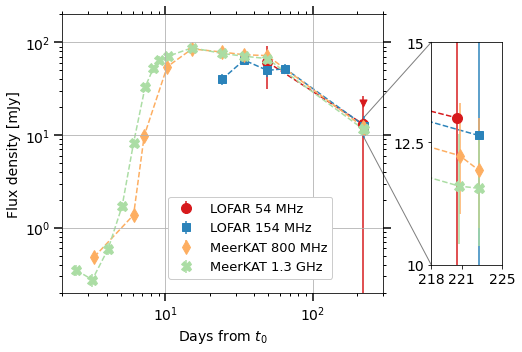

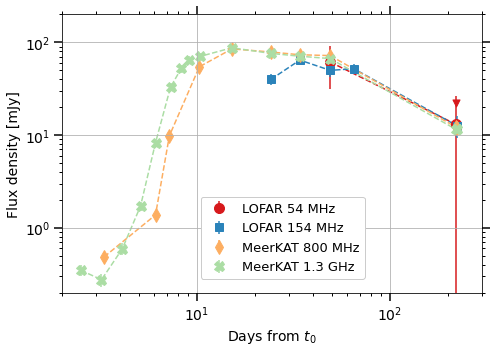

In [13]:


sub_select = [0,1,6,7]


plot_simple(sub_select, zoom=True)
plot_simple(sub_select, zoom=False)

In [29]:
def format_residual(ax1, ax2, lims):
    """Format the axis that contain the residual."""
    ax2.set_xlabel('Time [day]')
    ax1.set_ylabel('|Residual|')
    
    ax1.set_ylim(lims[0])
    ax2.set_ylim(lims[1])
    
    ax1.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax1.xaxis.tick_top()
    ax1.tick_params(labeltop='off')  # don't put tick labels at the top
    ax2.xaxis.tick_bottom()
    ax1.grid()
    ax2.grid()
    d = .015  # how big to make the diagonal lines in axes coordinates
    # arguments to pass to plot, just so we don't keep repeating them
    kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
    ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
    ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

    kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
    ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

    
    

In [27]:
def plot_two_fits(sub_select, popt_one, popt_two, folder):
    """Plot the single and double component fits."""

    color_list = ['#d7191c', '#2b83ba', 'c', 'c', 'c', 'c', 
                  '#fdae61', '#abdda4', 'c', 'c', 'c', 'c', 'c']
    marker_list = ['o', 's', 'o', 'o', 'o', 'o', 
                   'd', 'X', 'o', 'o', 'o', 'o', 'o']
    size_list = [10, 8, 1,1,1,1,
                 10, 10, 1,1,1,1,1]
    x_list = np.logspace(np.log10(3), np.log10(400), 100)
    nu_list = [54, 154, 150, 240, 325, 610, 830, 1280, 2600, 3400,5100, 1700,1700]
    
    popt_one = list(popt_one)
    popt_two = list(popt_two)
    fig, axs = plt.subplots(2,2, figsize=(14,8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
    
    # Plot single component fit
    x = []
    y = []
    residual_list = []
    day_list = []
    for i in sub_select:
        axs[0,0].errorbar(data[i]['Day'], data[i]['Flux_mJy'], yerr=data[i]['Error_mJy'], linestyle='none',
                     c = color_list[i], marker=marker_list[i], markersize=size_list[i], label = label_list[i])

        popt_plus_nu = popt_one+[nu_list[i]/1000]
        
        y_list = model(x_list, *popt_plus_nu)
        residual = (data[i]['Flux_mJy'] - model(data[i]['Day'], *popt_plus_nu))**2 / data[i]['Error_mJy']**2
        x.append(x_list)
        y.append(y_list)
        axs[0,0].plot(x_list, y_list, linestyle='--', linewidth=2,
                 c=color_list[i], zorder=0)
        
        residual_list.append(residual)
        day_list.append(np.ravel(data[i]['Day']))

    axs[0,0].scatter(data[0]['Day'][-1], 3*7.42, marker='v', s=50, c = color_list[0])

    axs[0,0].set_ylabel('Flux density [mJy]')
    axs[0,0].set_xscale('log')
    axs[0,0].set_yscale('log')
    axs[0,0].set_ylim(0.2, 500)
    axs[0,0].set_xlim(2, 400)
    axs[0,0].grid()
    axs[0,0].legend(loc='upper right', fontsize=13, framealpha=1, ncol=2)
    axs[0,0].set_title('One component', fontsize = 18)
    format_ax(axs[0,0])
    
    
    # Plot residual of single component fit
    for i, entry in enumerate(day_list):
        axs[1,0].plot(day_list[i], residual_list[i], marker=marker_list[sub_select[i]],markersize=size_list[sub_select[i]], c=color_list[sub_select[i]])

    axs[1,0].set_xlabel('Time [day]')
    axs[1,0].set_ylabel('Residual')
    axs[1,0].set_xscale('log')
    axs[1,0].set_xlim(2, 400)
    axs[1,0].set_ylim(-5, 100)
    format_ax(axs[1,0])
    
    
    chisq = chi_square(popt_one, sub_select, model_type='simple')
    axs[1,0].text(10.1,50, r"$\chi_{\nu}^2$"+"={:.1f}".format(chisq), fontsize=14)
    axs[1,0].grid()
    
    
    # Plot two component fit
    residual_list = []
    day_list = []
    for i in sub_select:
        axs[0,1].errorbar(data[i]['Day'], data[i]['Flux_mJy'], yerr=data[i]['Error_mJy'], linestyle='none',
                     c = color_list[i], marker=marker_list[i], markersize=size_list[i], label = label_list[i])

        popt_plus_nu = popt_two+[nu_list[i]/1000]
        
        y_list = model_total(x_list, *popt_plus_nu)
        print(label_list[i])
        # Extrapolate flux to 15 years
        print('Flux value after 15 years ', model_total(np.array([15*365, 15*365]), *popt_plus_nu))
        residual = (data[i]['Flux_mJy'] - model_total(data[i]['Day'], *popt_plus_nu))**2 / data[i]['Error_mJy']**2
        
        
        y_list = model_total(x_list, *popt_plus_nu)
        # Plot single components seperately
        popt1 = popt_two[:8]+[nu_list[i]/1000]
        axs[0,1].plot(x_list, model(x_list, *popt1), linestyle=':', c=color_list[i], linewidth=2, zorder=0)
        popt2 = popt_two[8:]+[nu_list[i]/1000]
        axs[0,1].plot(x_list, model(x_list, *popt2), linestyle=':', c=color_list[i], linewidth=2, zorder=0)
        # Plot total fit
        axs[0,1].plot(x_list, y_list, linestyle='--', linewidth=2,
                 c=color_list[i])

        residual_list.append(residual)
        day_list.append(np.ravel(data[i]['Day']))

    axs[0,1].scatter(data[0]['Day'][-1], 3*7.42, marker='v', s=50, c = color_list[0])
    axs[0,1].set_ylim(0.2, 500)
    axs[0,1].set_yscale('log')
    axs[0,1].set_yticklabels([])
    axs[0,1].grid()
    axs[0,1].set_title('Two components', fontsize = 18)
    format_ax(axs[0,1])
    
    # Include legend that shows that the dashed lines are the total fits and the dotted lines are the single components.
    custom_lines = [Line2D([0], [0], color='k', linestyle='--'),
                    Line2D([0], [0], color='k', linewidth=2, linestyle=':')]
    axs[0,1].legend(custom_lines, ['Fit', 'Single component'])
    
    # Plot residual of two component fit
    for i, entry in enumerate(day_list):
        
        axs[1,1].plot(day_list[i], residual_list[i], marker=marker_list[sub_select[i]],markersize=size_list[sub_select[i]], c=color_list[sub_select[i]])

    axs[1,1].set_xlabel('Time [day]')
    format_ax(axs[1,1])
    axs[1,1].set_yticklabels([])
    chisq = chi_square(popt_two, sub_select, model_type='full')
    axs[1,1].text(10.1,50, r"$\chi_{\nu}^2$"+"={:.1f}".format(chisq), fontsize=14)
    axs[1,1].grid()
    axs[1,1].set_ylim(-5, 100)
    
    plt.tight_layout()
    #plt.savefig('{}/lightcurve_fits.png'.format(folder), bbox_inches='tight')
    plt.show()
    


In [32]:
def chi_square(popt, sub_select, model_type):
    """Calculate a chi-sq measure of the fit over all frequencies."""
    
    chi_sub = 0
    nof_obs = 0
    nu_list = [54, 154, 150, 240, 325, 610, 830, 1280, 2600, 3400,5100, 1700,1700]
    
    for i in sub_select:
        nof_obs += len(data[i]['Day'])
        if model_type=='full':
            mod_value = model_total(data[i]['Day'],*popt, nu_list[i]/1000)
        else:
            mod_value = model(data[i]['Day'],*popt, nu_list[i]/1000)

        chi_sub += sum(((data[i]['Flux_mJy']-mod_value)**2)/data[i]['Error_mJy']**2)
    
    
    DOF = nof_obs -len(popt) - 1
    print(chi_sub, DOF)
    return chi_sub/DOF




525.13441034239424543 23
LOFAR 54 MHz
Flux value after 15 years  [0.5700509 0.5700509]
LOFAR 154 MHz
Flux value after 15 years  [0.34548163 0.34548163]
MeerKAT 800 MHz
Flux value after 15 years  [0.27863125 0.27863125]
MeerKAT 1.3 GHz
Flux value after 15 years  [0.20269214 0.20269214]
224.687636695591161 15


<ipython-input-5-86705ffcdfcd>:10: RuntimeWarning: overflow encountered in exp
  S = K1 * (nu)**(alpha) * np.sign(a)*(np.abs(a))**beta * np.exp(np.float128(-1*t_csm_homog)) * ((1-np.exp(np.float128(-1*t_csm_clumps)))/t_csm_clumps)


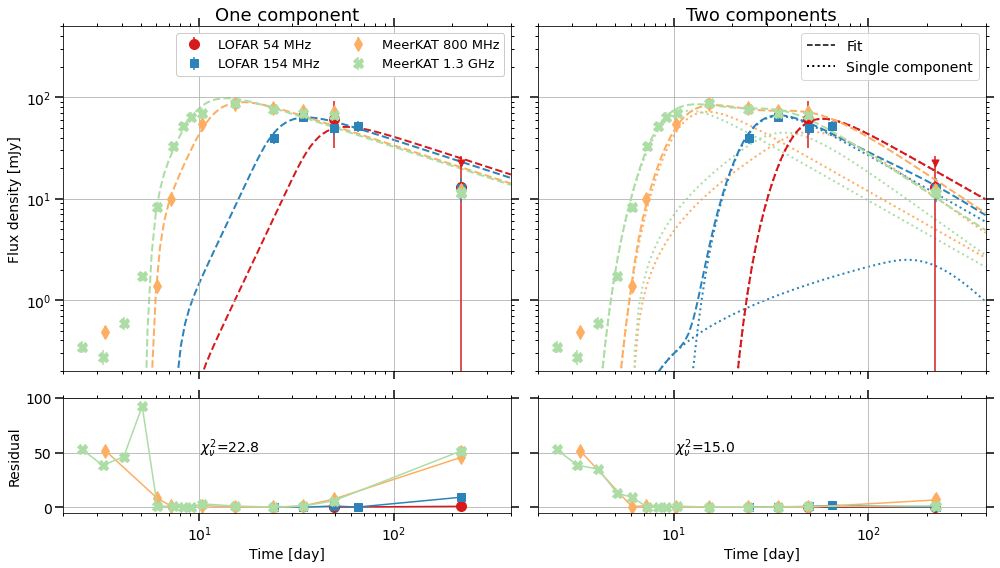

In [33]:


sub_select = [0,1,6,7]

folder = 'plot'

plot_two_fits(sub_select, popt_one=popt_fit_simple, popt_two=popt_fit_full, folder=folder)


## Compare chi-sq values

In [34]:
def RSS(popt, sub_select, model_type):
    """Calculate a chi-sq measure of the fit over all frequencies."""
    nu_list = [54, 154, 150, 240, 325, 610, 830, 1280, 2600, 3400,5100, 1700,1700]
    RSS = 0
    nof_obs = 0
    for i in sub_select:
        nof_obs += len(data[i]['Day'])
        if model_type=='full':
            mod_value = model_total(data[i]['Day'],*popt, nu_list[i]/1000)
        else:
            mod_value = model(data[i]['Day'],*popt, nu_list[i]/1000)
        
        RSS += sum((data[i]['Flux_mJy']-mod_value)**2)
        
    return RSS, len(popt), nof_obs



def f_stat(sub_select):
    """Calculate f-statistic."""
    RSS_simple, k_simple, n_simple = RSS(popt_fit_simple, sub_select, model_type='simple')
    RSS_full, k_full, n_full = RSS(popt_fit_full, sub_select, model_type='full')

    print(RSS_simple, k_simple, n_simple)
    print(RSS_full, k_full, n_full)
    
    a = (RSS_simple-RSS_full)/(k_full - k_simple)
    b= RSS_full/(n_full-k_full)
    return float(a/b), n_simple-k_simple-1, n_full-k_full-1

sub_select = [0,1,6,7]

f, dfn, dfd = f_stat(sub_select)
p = 1-stats.f.cdf(f, dfd, dfn)
print(p)
print('p smaller than 0.05 -> second model is a better fit')

1870.7907161211068325 8 32
362.03218491038569932 16 32
4.623880363707755e-06
p smaller than 0.05 -> second model is a better fit


## Brightness temperature

In the Rayleigh-Jeans limit:
\begin{equation}
    I_{\nu} = \frac{2k_B\nu^2}{c^2}T_b
\end{equation}
where $I_{\nu}$ (the Intensity or Brightness) is the amount of energy emitted per unit surface area per unit time per unit solid angle. The flux density is given by 
\begin{equation}
    S_{\nu} = \int_{\rm{source}} I_{\nu} d\Omega
\end{equation}
\begin{equation}
    S_{\nu} = \frac{2k_B\nu^2}{c^2}T_b \int d\Omega
\end{equation}


<img src="solid_angle.png" alt="solid angle" width="300"/>

An object's solid angle in steradians is equal to the area of the segment of a unit sphere, centered at the apex, that the object covers.
\begin{equation}
    \Omega = \frac{A}{d^2} \approx \frac{\pi R^2}{d^2}
\end{equation}

\begin{equation}
    S_{\nu} = \frac{2k_B\nu^2}{c^2}T_b \frac{\pi R^2}{d^2}
\end{equation}

\begin{equation}
    T_b = \frac{S_{\nu} \cdot c^2}{2k_B\nu^2}\frac{d^2}{\pi R^2}
    \label{eq:brightness_temp}
\end{equation}
The constants in SI: $k_B = 1.38 \cdot 10^{-23} \; \rm{m}^2\rm{kg} \rm{s}^{-2}\rm{K}^{-1}$ and $c = 3 \cdot 10^8 \; \rm{ms}^{-1}$.

In [35]:
# Brightness temperature

c = 3e8 # m/s
kb = 1.38e-23 # J/K

pc_to_m = 3.08e16
mJy_to_SI = 1e-29

 


def T_b(S, nu, days, vexp, dist, flux_error):
    """Calculate the brigthness temperature."""
    # S in mJy
    # distance in m
    
    # Radius/size of emitting blob
    R = vexp * days*24*3600*1e3
    
    return (c**2 * (S+flux_error)* mJy_to_SI * dist**2) / (2* kb* nu**2 * math.pi * R**2)


print('O Brien brightness temperature is')
print(T_b(4.7, c/0.18, 13.8, 1730, 2600*pc_to_m, 0))



def plot_brightness(dist, vexp, flux_error_sign, nu):
    """Create the plot lists for the brightness temperature as a function of observing date."""
    dist = dist * pc_to_m # m
    
    nu_list = [54, 154, 150, 240, 325, 610, 800]
    i = nu_list.index(nu)
    
    flux_error = [[29.7, 29.7], [5.65, 7.63, 7.35, 6.5, 3.44]]
    
    days = data[i]['Day']
    
    Tb_list = []
    for d, day in enumerate(days):
        Tb = T_b(data[i]['Flux_mJy'][d], nu*1e6, day, vexp, dist, flux_error_sign* flux_error[i][d])
        Tb_list.append(Tb)
        
    
    return np.array(Tb_list), days
    


O Brien brightness temperature is
26470014.445402443


[1.46834036e+09 1.55289430e+07]
1.4683403612096828 0.6493647930112554 2.565338760485493
[4.82407588e+08 3.90560237e+08 1.46030648e+08 8.69999974e+07
 1.81254601e+06]
4.8240758796485945 3.5470958262488224 6.484815083546316


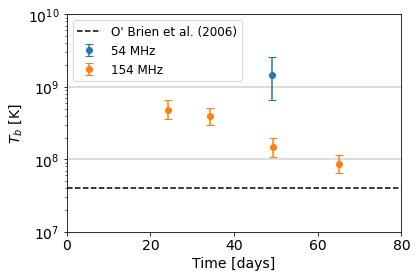

In [36]:


# The brightness temperature at 54 MHz
# Assuming the highest distance and slowest expansion yields the maximum brightness temperature
Tb_list_max_54, days_54 = plot_brightness(dist=2850, vexp=7500-150, flux_error_sign=1, nu=54) # highest

# Assuming the lowest distance and highest expansion yields the minimum brightness temperature
Tb_list_min_54, days_54 = plot_brightness(dist=2530, vexp=7500+150, flux_error_sign=-1, nu=54) # lowest

# Assuming the middle values in the confidence intervals for distance and expansion velocity
Tb_list_54, days_54 = plot_brightness(dist=2680, vexp=7500, flux_error_sign=0, nu=54)

plt.errorbar(days_54, Tb_list_54, fmt='o', capsize=4, yerr=[Tb_list_54-Tb_list_min_54, Tb_list_max_54-Tb_list_54], label='54 MHz')

# Same process for the 154 MHz measurements
Tb_list_max_154, days_154 = plot_brightness(dist=2850, vexp=7500-150, flux_error_sign=1, nu=154) # highest
Tb_list_min_154, days_154 = plot_brightness(dist=2530, vexp=7500+150, flux_error_sign=-1, nu=154) # lowest
Tb_list_154, days_154 = plot_brightness(dist=2680, vexp=7500, flux_error_sign=0, nu=154) # lowest
plt.errorbar(days_154, Tb_list_154, fmt='o', capsize=4, yerr=[Tb_list_154-Tb_list_min_154, Tb_list_max_154-Tb_list_154], label='154 MHz')

print(Tb_list_54)
print(Tb_list_54[0]/1e9, Tb_list_min_54[0]/1e9, Tb_list_max_54[0]/1e9)

print(Tb_list_154)
print(Tb_list_154[0]/1e8, Tb_list_min_154[0]/1e8, Tb_list_max_154[0]/1e8)

plt.yscale('log')
plt.xlim(0, 80)
plt.ylim(1e7, 1e10)
plt.axhline(1e8, c= 'lightgrey', zorder=0)
plt.axhline(1e9, c= 'lightgrey', zorder=0)
plt.axhline(1e10, c= 'lightgrey', zorder=0)
plt.axhline(1e11, c= 'lightgrey', zorder=0)
plt.axhline(4e7, c='k', linestyle='--', label='O\' Brien et al. (2006)')
plt.legend(loc='upper left', fontsize=12)
plt.xlabel('Time [days]')
plt.ylabel(r'$T_b$ [K]')
#plt.savefig('plot/brightness_temperature2.png', bbox_inches = 'tight')
plt.show()